In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

import gymnasium as gym
import gym_trading_env

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from RLTrade.agent import DQNAgent, XGBoostAgent
from RLTrade.utils import (
    stationaryDGP, 
    nonstationaryDGP, 
    # build_features, 
    # build_rolling_feature
    FeatureEngineering
)

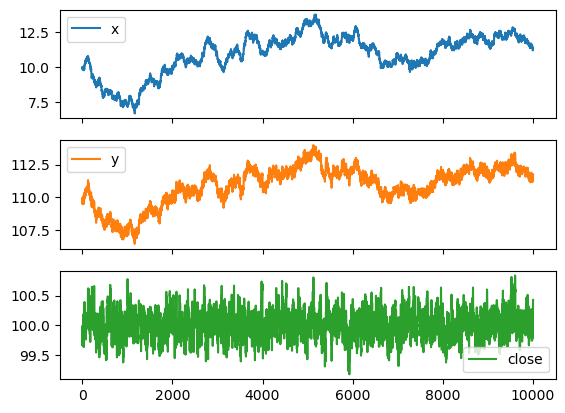

In [2]:
x, y = stationaryDGP()
spread = y - x
df = pd.DataFrame({'x': x, 'y': y, 'close': spread}) # close price of portfolio is the spread
df.plot(subplots=True)
plt.show()

In [3]:
# confirm the x, y pair is cointegrated, such that spread is stationary
x_ols = sm.add_constant(x)
ols = sm.OLS(y, x_ols).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                 4.073e+05
Date:                Wed, 05 Jun 2024   Prob (F-statistic):               0.00
Time:                        23:04:16   Log-Likelihood:                 746.19
No. Observations:               10000   AIC:                            -1488.
Df Residuals:                    9998   BIC:                            -1474.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         99.9939      0.017   5792.312      0.0

In [4]:
adfuller_test = adfuller(spread)
print(f'ADF Statistic: {adfuller_test[0]}')
print(f'p-value: {adfuller_test[1]}')
print('Is the spread stationary? {}'.format('Yes' if adfuller_test[1] < 0.05 else 'No'))

ADF Statistic: -23.624303774542252
p-value: 0.0
Is the spread stationary? Yes


In [5]:
# build features
df_train = df.copy()

feature_config = {
    "window": 7, # 7 days window, pad with first value when window is not available
    "mode": "diff", # difference between current and previous close price
    "subtract_mean": True, # subtract mean from the window
}

fe = FeatureEngineering(df_train, main_feature_col="close")
fe.rolling_feature(**feature_config)
df_train = fe.df.copy()
df_train

,x,y,close,feature_rolling_0,feature_rolling_1,feature_rolling_2,feature_rolling_3,feature_rolling_4,feature_rolling_5,feature_rolling_6
0,9.952140,109.929877,99.977736,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,9.953234,109.821062,99.867828,-0.054954,0.054954,0.054954,0.054954,0.054954,0.054954,0.054954
2,9.970898,109.666858,99.695960,-0.077942,-0.015983,0.093925,0.093925,0.093925,0.093925,0.093925
3,9.845759,109.517669,99.671910,0.052406,-0.095411,-0.033452,0.076457,0.076457,0.076457,0.076457
4,9.835525,109.653331,99.817806,0.177882,0.007935,-0.139881,-0.077923,0.031986,0.031986,0.031986
...,...,...,...,...,...,...,...,...,...,...
9995,11.266501,111.250543,99.984042,-0.046866,-0.097044,-0.072946,0.090331,0.063302,-0.046692,0.109915
9996,11.264361,111.366934,100.102573,0.101266,-0.045425,-0.095603,-0.071504,0.091773,0.064743,-0.045251
9997,11.329527,111.509216,100.179689,0.044838,0.086252,-0.060440,-0.110618,-0.086519,0.076758,0.049728
9998,11.295573,111.604869,100.309297,0.090529,0.038038,0.079452,-0.067240,-0.117418,-0.093319,0.069958


In [6]:
# Define the environment
env_action_space = [-1, 0, 1] # Positions : [-1=SHORT, 0=OUT, 1=LONG]
# env_action_space = [i/10 for i in range(-10, 11)] # Positions : [-1, -0.9, -0.8, ..., 0, 0.1, 0.2, ..., 1]

env = gym.make("TradingEnv",
        name= "stationaryDGP",
        df = df_train, # Your dataset with your custom features
        positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        # max_episode_duration=180
    )
env.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
env.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

# Run an episode until it ends :
done, truncated = False, False
observation, info = env.reset()
print(observation)

while not done and not truncated:
    # Pick a position by its index in your position list (=[-1, 0, 1])....usually something like : position_index = your_policy(observation)
    position_index = env.action_space.sample() # At every timestep, pick a random position index from your position list (=[-1, 0, 1])
    observation, reward, done, truncated, info = env.step(position_index)

n_actions = env.action_space.n
n_observations = len(env.reset()[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0.]
Market Return :  0.45%   |   Portfolio Return : -60.52%   |   Position Changes : 6665   |   Episode Length : 10000   |   


In [11]:
# Train a DQN agent using training data from a stationary data generating process
agent = DQNAgent(n_observations=n_observations, n_actions=n_actions)
history_metrics, _ = agent.train(env, num_episodes=15) # Beware of overfitting when num_episodes is too high

Market Return :  0.45%   |   Portfolio Return : -44.63%   |   Position Changes : 5721   |   Episode Length : 10000   |   
Market Return :  0.45%   |   Portfolio Return : -40.92%   |   Position Changes : 4918   |   Episode Length : 10000   |   
Market Return :  0.45%   |   Portfolio Return : -31.06%   |   Position Changes : 4837   |   Episode Length : 10000   |   
Market Return :  0.45%   |   Portfolio Return : -36.59%   |   Position Changes : 4733   |   Episode Length : 10000   |   
Market Return :  0.45%   |   Portfolio Return : -33.96%   |   Position Changes : 4705   |   Episode Length : 10000   |   
Market Return :  0.45%   |   Portfolio Return : -29.39%   |   Position Changes : 4585   |   Episode Length : 10000   |   
Market Return :  0.45%   |   Portfolio Return : -28.24%   |   Position Changes : 4738   |   Episode Length : 10000   |   
Market Return :  0.45%   |   Portfolio Return : -37.22%   |   Position Changes : 4608   |   Episode Length : 10000   |   
Market Return :  0.45%  

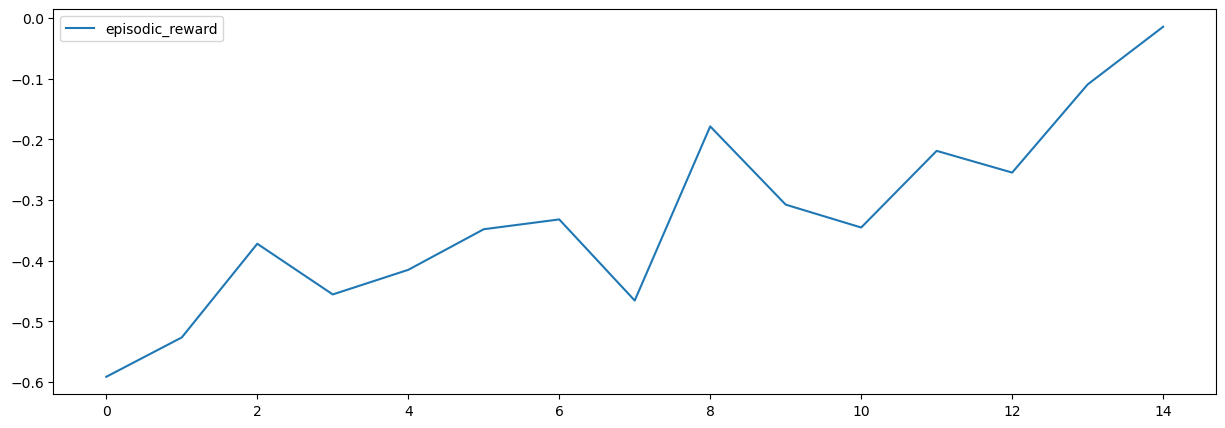

In [12]:
all_metrics = pd.DataFrame(history_metrics)
perc2float = lambda x: float(x.strip('%'))/100

all_metrics["Market Return"] = all_metrics["Market Return"].apply(perc2float)
all_metrics["Portfolio Return"] = all_metrics["Portfolio Return"].apply(perc2float)

all_metrics.plot(y=["episodic_reward"], figsize=(15, 5))
plt.show()

In [13]:
# Evaluate the agent on a new dataset from the same data generating process
returns = []
for i in range(10):
    x, y = stationaryDGP()
    spread = y - x
    _df = pd.DataFrame({'x': x, 'y': y, 'close': spread})
    fe = FeatureEngineering(_df, main_feature_col="close")
    fe.rolling_feature(**feature_config)
    _df = fe.df.copy()
    
    env_test = gym.make("TradingEnv",
            name= "stationaryDGP",
            df = _df, # Your dataset with your custom features
            positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
            trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
            borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        )
    env_test.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
    env_test.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

    env_test = agent.eval(env_test)
    returns.append(perc2float(env_test.unwrapped.get_metrics()["Portfolio Return"]))

print(f"Average Portfolio Return: {np.mean(returns)}")
print(f"Std Portfolio Return: {np.std(returns)}")

Market Return :  0.22%   |   Portfolio Return : -19.20%   |   Position Changes : 2234   |   Episode Length : 10000   |   
Market Return : -0.13%   |   Portfolio Return : -13.09%   |   Position Changes : 2320   |   Episode Length : 10000   |   
Market Return :  0.03%   |   Portfolio Return : -20.73%   |   Position Changes : 2252   |   Episode Length : 10000   |   
Market Return : -0.07%   |   Portfolio Return : -21.50%   |   Position Changes : 2277   |   Episode Length : 10000   |   
Market Return :  0.48%   |   Portfolio Return : -22.00%   |   Position Changes : 2185   |   Episode Length : 10000   |   
Market Return :  0.05%   |   Portfolio Return : -24.78%   |   Position Changes : 2234   |   Episode Length : 10000   |   
Market Return : -0.01%   |   Portfolio Return : -16.86%   |   Position Changes : 2252   |   Episode Length : 10000   |   
Market Return : -0.01%   |   Portfolio Return : -20.26%   |   Position Changes : 2220   |   Episode Length : 10000   |   
Market Return : -0.02%  

In [14]:
# from gym_trading_env.renderer import Renderer
# renderer = Renderer(render_logs_dir="render_logs")
# renderer.run()

In [15]:
# build features
df_train = df.copy()

feature_config = {
    "window": 1, # 7 days window, pad with first value when window is not available
    "mode": "diff" # difference between current and previous close price
}

fe = FeatureEngineering(df_train, main_feature_col="close")
fe.rolling_feature(**feature_config)
df_train = fe.df.copy()
df_train

,x,y,close,feature_rolling_0
0,9.952140,109.929877,99.977736,0.000000
1,9.953234,109.821062,99.867828,-0.109909
2,9.970898,109.666858,99.695960,-0.171867
3,9.845759,109.517669,99.671910,-0.024051
4,9.835525,109.653331,99.817806,0.145896
...,...,...,...,...
9995,11.266501,111.250543,99.984042,-0.028161
9996,11.264361,111.366934,100.102573,0.118530
9997,11.329527,111.509216,100.179689,0.077117
9998,11.295573,111.604869,100.309297,0.129607


In [16]:
# Define the environment
env_action_space = [-1, 0, 1] # Positions : [-1=SHORT, 0=OUT, 1=LONG]
# env_action_space = [i/10 for i in range(-10, 11)] # Positions : [-1, -0.9, -0.8, ..., 0, 0.1, 0.2, ..., 1]

env = gym.make("TradingEnv",
        name= "stationaryDGP",
        df = df_train, # Your dataset with your custom features
        positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        # max_episode_duration=180
    )
env.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
env.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

# Run an episode until it ends :
done, truncated = False, False
observation, info = env.reset()
print(observation)
while not done and not truncated:
    # Pick a position by its index in your position list (=[-1, 0, 1])....usually something like : position_index = your_policy(observation)
    position_index = env.action_space.sample() # At every timestep, pick a random position index from your position list (=[-1, 0, 1])
    observation, reward, done, truncated, info = env.step(0)

n_actions = env.action_space.n
n_observations = len(env.reset()[0])

[ 0. -1. -1.]
Market Return :  0.45%   |   Portfolio Return : -0.45%   |   Position Changes : 0   |   Episode Length : 10000   |   


In [17]:
agent = XGBoostAgent(n_observations, n_actions)
history_metrics, _ = agent.train(env, num_episodes=20, replay_every=2)

Market Return :  0.45%   |   Portfolio Return : -59.12%   |   Position Changes : 6706   |   Episode Length : 10000   |   
Market Return :  0.45%   |   Portfolio Return : -54.75%   |   Position Changes : 6705   |   Episode Length : 10000   |   
Market Return :  0.45%   |   Portfolio Return : -54.71%   |   Position Changes : 5725   |   Episode Length : 10000   |   
Market Return :  0.45%   |   Portfolio Return : -40.27%   |   Position Changes : 5670   |   Episode Length : 10000   |   
Market Return :  0.45%   |   Portfolio Return : -14.17%   |   Position Changes : 4437   |   Episode Length : 10000   |   
Market Return :  0.45%   |   Portfolio Return : -24.24%   |   Position Changes : 4442   |   Episode Length : 10000   |   
Market Return :  0.45%   |   Portfolio Return :  2.74%   |   Position Changes : 2647   |   Episode Length : 10000   |   
Market Return :  0.45%   |   Portfolio Return : 11.85%   |   Position Changes : 2516   |   Episode Length : 10000   |   
Market Return :  0.45%   |

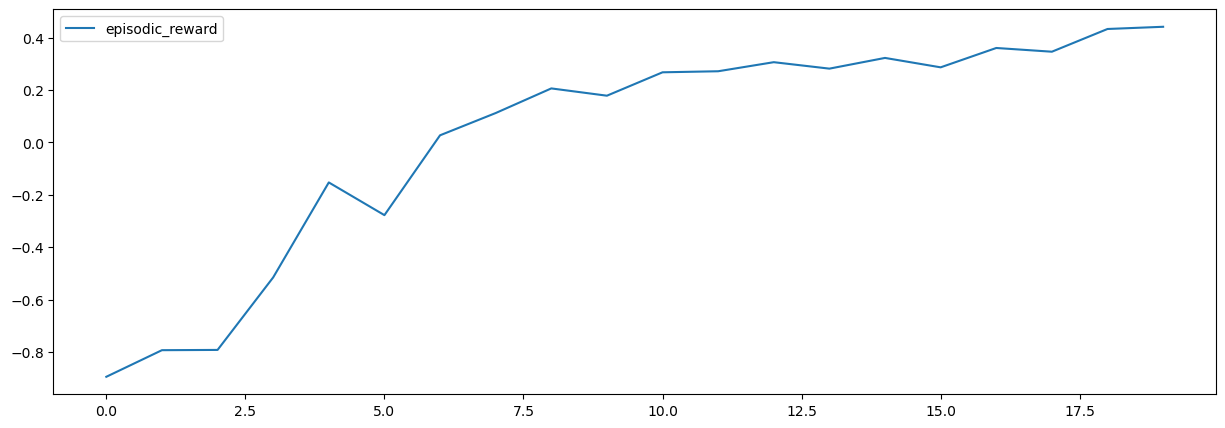

In [18]:
all_metrics = pd.DataFrame(history_metrics)
perc2float = lambda x: float(x.strip('%'))/100

all_metrics["Market Return"] = all_metrics["Market Return"].apply(perc2float)
all_metrics["Portfolio Return"] = all_metrics["Portfolio Return"].apply(perc2float)

all_metrics.plot(y=["episodic_reward"], figsize=(15, 5))
plt.show()

In [19]:
# Evaluate the agent on a new dataset from the same data generating process
returns = []
for i in range(10):
    x, y = stationaryDGP()
    spread = y - x
    _df = pd.DataFrame({'x': x, 'y': y, 'close': spread})
    fe = FeatureEngineering(_df, main_feature_col="close")
    fe.rolling_feature(**feature_config)
    _df = fe.df.copy()

    env_test = gym.make("TradingEnv",
            name= "stationaryDGP",
            df = _df, # Your dataset with your custom features
            positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
            trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
            borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        )
    env_test.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
    env_test.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

    env_test = agent.eval(env_test)
    returns.append(perc2float(env_test.unwrapped.get_metrics()["Portfolio Return"]))

print(f"Average Portfolio Return: {np.mean(returns)}")
print(f"Std Portfolio Return: {np.std(returns)}")

Market Return :  0.32%   |   Portfolio Return : 37.63%   |   Position Changes : 1343   |   Episode Length : 10000   |   
Market Return : -0.29%   |   Portfolio Return : 40.41%   |   Position Changes : 1341   |   Episode Length : 10000   |   
Market Return : -0.11%   |   Portfolio Return : 46.46%   |   Position Changes : 1310   |   Episode Length : 10000   |   
Market Return :  0.35%   |   Portfolio Return : 39.26%   |   Position Changes : 1362   |   Episode Length : 10000   |   
Market Return : -0.12%   |   Portfolio Return : 43.92%   |   Position Changes : 1314   |   Episode Length : 10000   |   
Market Return : -0.09%   |   Portfolio Return : 49.58%   |   Position Changes : 1374   |   Episode Length : 10000   |   
Market Return : -0.17%   |   Portfolio Return : 58.70%   |   Position Changes : 1373   |   Episode Length : 10000   |   
Market Return :  0.07%   |   Portfolio Return : 44.11%   |   Position Changes : 1314   |   Episode Length : 10000   |   
Market Return :  0.13%   |   Por